# Identifying Fraudulent Activities
## Goal
E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc.
Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

## Challenge Description
Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

These are the tasks you are asked to do:
1. For each user, determine her country based on the numeric IP address.
2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
3. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
4. Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import graphviz

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [5]:
data = pd.read_csv('Fraud_Data.csv')
IpAddress_to_Country = pd.read_csv('IpAddress_to_Country.csv')

In [6]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [7]:
IpAddress_to_Country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Determine user' country based on the numeric IP address.

In [8]:
countries = []
for i in range(len(data)):
    ip_address = data.loc[i,'ip_address']
    tmp = IpAddress_to_Country[(IpAddress_to_Country['lower_bound_ip_address'] <= ip_address) &
                          (IpAddress_to_Country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
data['country'] = countries    

In [9]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Before jumping into building a model, think about whether you can create new powerful variables. This is called feature engineering and it is the most important step in machine learning. However, feature engineering is quite time consuming. In a take-home you should just give an idea of how you would do it and emphasize that with more time you would go deeper into it.

A few obvious variables that can be created here could be:
1. Time difference between sign-up time and purchase time
2. If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
3. Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
4. Usual week of the year and day of the week from time variables

## Feature enigeering 

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [14]:
# change object data type to date data type 
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

In [18]:
# Get the time difference between purchase time and signup time
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [19]:
time_diff

0         13882
1         17944
2             1
3         60085
4         41461
          ...  
151107    77233
151108    67270
151109    28816
151110    48519
151111    68493
Length: 151112, dtype: int64

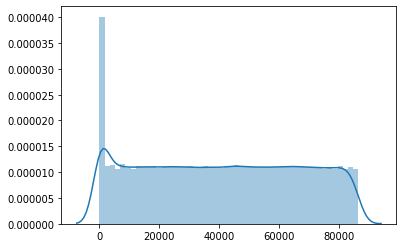

In [20]:
sns.distplot(time_diff)

In [28]:
# count for unique devices
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'}) # number of users 
data = data.merge(device_num, how='left', on='device_id')

In [29]:
# count for unique ip_address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [30]:
# signupday and week 
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

In [31]:
# purchase day and week 
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [32]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [33]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


## Fraudulent Activity Identification

In [36]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/70/03x2hqsd6hlbxgztv4sps06m0000gn/T/tmps33isr8i
  JVM stdout: /var/folders/70/03x2hqsd6hlbxgztv4sps06m0000gn/T/tmps33isr8i/h2o_opheliaming_started_from_python.out
  JVM stderr: /var/folders/70/03x2hqsd6hlbxgztv4sps06m0000gn/T/tmps33isr8i/h2o_opheliaming_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Europe/Amsterdam
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 4 days
H2O_cluster_name:,H2O_from_python_opheliaming_6m9bgt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [38]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

for name in ['signup_day', 'purchase_day','class']:
    h2o_df[name] = h2o_df[name].asfactor()

#h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [39]:
# Split into 80% training and 20% test dataset
train, test = h2o_df.split_frame(ratios = [0.8], seed = 1234)
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num']
target = 'class'

In [40]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


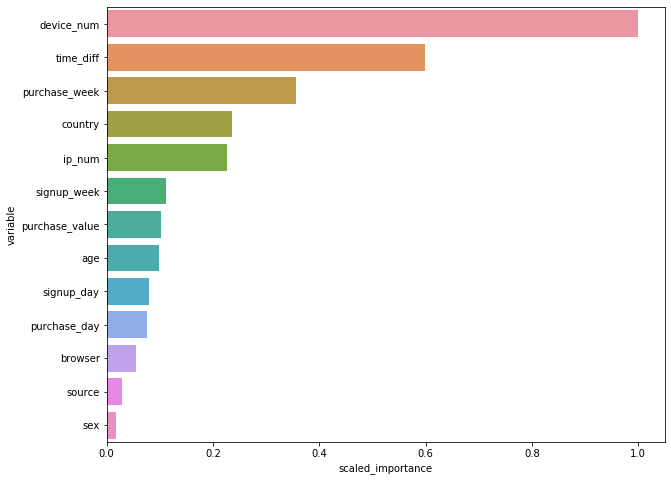

In [41]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [42]:
# retrive model performance
perf = model.model_performance(test)
perf


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.038900015053648075
RMSE: 0.19723086739566928
LogLoss: 0.18381914048644912
Mean Per-Class Error: 0.18204816436599836
AUC: 0.8445042304747826
AUCPR: 0.7146362945962107
Gini: 0.6890084609495652

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2823471747427978: 


,,0,1,Error,Rate
0,0,27347.0,8.0,0.0003,(8.0/27355.0)
1,1,1244.0,1516.0,0.4507,(1244.0/2760.0)
2,Total,28591.0,1524.0,0.0416,(1252.0/30115.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.282347,0.707750,15.0
1,max f2,0.047319,0.658753,190.0
2,max f0point5,0.986882,0.857955,3.0
3,max accuracy,0.986882,0.958492,3.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000008,1.000000,399.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.986882,0.723321,3.0
8,max min_per_class_accuracy,0.023261,0.765942,266.0
9,max mean_per_class_accuracy,0.039700,0.817952,206.0



Gains/Lift Table: Avg response rate:  9.16 %, avg score:  7.01 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.049875,1.000000,10.911232,10.911232,1.000000,1.000000,1.000000,1.000000,0.544203,0.544203,991.123188,991.123188,0.544203
1,2,0.050008,0.992761,10.911232,10.911232,1.000000,0.994449,1.000000,0.999985,0.001449,0.545652,991.123188,991.123188,0.545652
2,3,0.100017,0.061010,2.427133,6.669183,0.222444,0.111663,0.611222,0.555824,0.121377,0.667029,142.713325,566.918257,0.624221
3,4,0.150025,0.032563,0.963608,4.767324,0.088313,0.041407,0.436919,0.384352,0.048188,0.715217,-3.639187,376.732442,0.622218
4,5,0.200000,0.027421,0.405999,3.677536,0.037209,0.029695,0.337041,0.295732,0.020290,0.735507,-59.400067,267.753623,0.589538
5,6,0.300017,0.022363,0.369504,2.574737,0.033865,0.024646,0.235971,0.205360,0.036957,0.772464,-63.049613,157.473673,0.520115
6,7,0.400000,0.018995,0.355131,2.019928,0.032547,0.020571,0.185124,0.159170,0.035507,0.807971,-64.486857,101.992754,0.449134
7,8,0.500017,0.016174,0.329655,1.681828,0.030212,0.017553,0.154137,0.130843,0.032971,0.840942,-67.034459,68.182821,0.375323
8,9,0.600000,0.013698,0.373250,1.463768,0.034208,0.014919,0.134152,0.111526,0.037319,0.878261,-62.674962,46.376812,0.306336
9,10,0.699983,0.011210,0.297151,1.297132,0.027233,0.012463,0.118880,0.097376,0.029710,0.907971,-70.284921,29.713222,0.228973


In [43]:
perf.accuracy()

[[0.9868821519392418, 0.9584924456251037]]

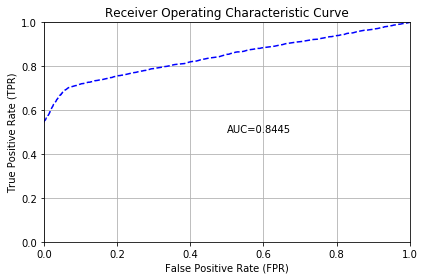

In [44]:
perf.plot(type = "roc")

“how to use this from a product perspective”: 
you now have a model that assigns to each user a probability of committing a fraud. You want to think about creating different experiences based on that. For instance:

1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.

This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives).